Saving plots to directory: /home/tisinr/Dev/models/classifier/notebooks/plots
No valid ROC curves to plot


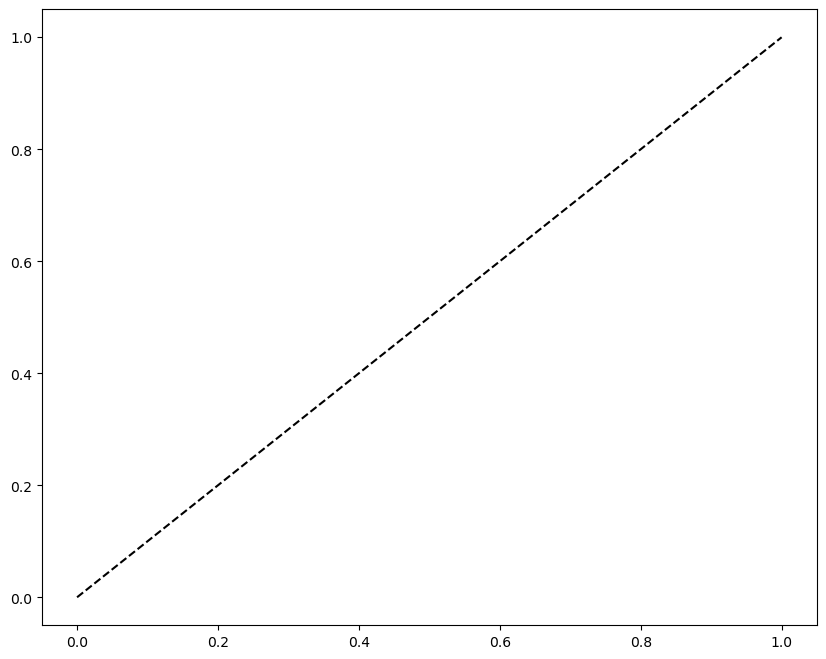

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_predict
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from lightgbm import early_stopping
import os
import warnings

def plot_all_models_roc(X_train, y_train, X_test, y_test, models, cv=5, plot_pr_curve=False, n_jobs=-1, save_format='png', save_dir='.'):
    
    # Input validation
    if not models:
        raise ValueError("Models list cannot be empty")
    for model_name, model in models:
        if not hasattr(model, 'predict_proba'):
            raise AttributeError(f"Model {model_name} does not support predict_proba")
        if not hasattr(model, 'fit') or not hasattr(model, 'predict'):
            raise AttributeError(f"Model {model_name} must be pre-fitted and support predict")

    # Ensure save directory exists
    os.makedirs(save_dir, exist_ok=True)
    print(f"Saving plots to directory: {os.path.abspath(save_dir)}")

    # Initialize figure for ROC curves
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

    # Initialize figure for precision-recall curves if requested
    if plot_pr_curve:
        plt_pr = plt.figure(figsize=(10, 8))

    def compute_metrics(model_name, model, X_train, y_train, X_test, y_test):
    
        try:
            # Use cross-validation for predicted probabilities
            y_pred_proba_cv = cross_val_predict(
                model, X_train, y_train, cv=cv, method='predict_proba', n_jobs=1
            )[:, 1]
            
            # Predict on test set
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            
            # Calculate ROC curve and AUC
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            roc_auc = auc(fpr, tpr)
            
            # Calculate precision-recall curve if requested
            precision, recall, _ = precision_recall_curve(y_test, y_pred_proba) if plot_pr_curve else (None, None, None)
            pr_auc = auc(recall, precision) if plot_pr_curve else None
            
            # Compute confusion matrix and classification report
            cm = confusion_matrix(y_test, y_pred)
            report = classification_report(y_test, y_pred, output_dict=True)
            
            return model_name, fpr, tpr, roc_auc, precision, recall, pr_auc, cm, report
        except Exception as e:
            warnings.warn(f"Error processing {model_name}: {str(e)}")
            return model_name, None, None, None, None, None, None, None, None

    # Sequential processing (uncomment Parallel block for parallelization)
    results = [compute_metrics(model_name, model, X_train, y_train, X_test, y_test)
               for model_name, model in models]

    # Plot ROC curves and print metrics
    valid_models = 0
    for model_name, fpr, tpr, roc_auc, precision, recall, pr_auc, cm, report in results:
        if fpr is not None:
            valid_models += 1
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
            print(f"\nResults for {model_name}:")
            print("Confusion Matrix:\n", cm)
            print("Classification Report:\n", classification_report(y_test, cm))
            if plot_pr_curve and precision is not None:
                plt_pr.plot(recall, precision, label=f'{model_name} (AUC = {pr_auc:.2f})')

    # Save ROC plot if at least one model produced valid results
    if valid_models > 0:
        try:
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic - Model Comparison')
            plt.legend(loc='lower right')
            plt.grid(True)
            
            roc_file = os.path.join(save_dir, f'roc_comparison.{save_format}')
            plt.savefig(roc_file, dpi=300, bbox_inches='tight')
            print(f"ROC plot saved as: {roc_file}")
        except Exception as e:
            print(f"Error saving ROC plot: {str(e)}")
        finally:
            plt.close()
    else:
        print("No valid ROC curves to plot")
        plt.close()

    # Save precision-recall plot if requested
    if plot_pr_curve and valid_models > 0:
        try:
            plt.figure(plt_pr.number)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title('Precision-Recall Curve - Model Comparison')
            plt.legend(loc='lower left')
            plt.grid(True)
            
            pr_file = os.path.join(save_dir, f'pr_comparison.{save_format}')
            plt.savefig(pr_file, dpi=300, bbox_inches='tight')
            print(f"Precision-Recall plot saved as: {pr_file}")
        except Exception as e:
            print(f"Error saving precision-recall plot: {str(e)}")
        finally:
            plt.close()

# Example usage with XGBoost and LightGBM
# Generate sample data
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize optimized models
xgb_model = XGBClassifier(
    n_estimators=1000,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42,
    eval_metric='logloss',
    early_stopping_rounds=10
)

lgb_model = LGBMClassifier(
    n_estimators=1000,
    max_depth=3,
    num_leaves=15,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=10,
    verbose=-1
)

# Fit models with early stopping
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    callbacks=[early_stopping(stopping_rounds=10, verbose=False)]
)

# Feature selection based on XGBoost importance
selector = SelectFromModel(xgb_model, prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Update models list with fitted models
models = [
    ('XGBoost', xgb_model),
    ('LightGBM', lgb_model)
]

# Call the function with an explicit save directory
save_dir = os.path.abspath('plots')  # Save to a 'plots' folder in the project directory
plot_all_models_roc(X_train_selected, y_train, X_test_selected, y_test, models, cv=5, plot_pr_curve=True, n_jobs=-1, save_format='png', save_dir=save_dir)